In [10]:
import experiments_func as exp
import matplotlib.pyplot as plt
import block_division_func as bd
import networkx as nx

In [11]:
# experiment = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

# random_nodes_random_result = []
# random_nodes_greedy_result = []
# top_nodes_random_result = []
# top_nodes_greedy_result = []

# for i, blocks in enumerate(experiment):
#     print(f'{i+1}回目, ブロック数: {blocks}')
#     random_nodes_random_cost, random_nodes_greedy_cost, top_nodes_random_cost, top_nodes_greedy_cost = exp.experiment(blocks)
#     random_nodes_random_result.append(random_nodes_random_cost)
#     random_nodes_greedy_result.append(random_nodes_greedy_cost)
#     top_nodes_random_result.append(top_nodes_random_cost)
#     top_nodes_greedy_result.append(top_nodes_greedy_cost)

In [12]:
experiment = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

random_nodes_random_result = []
random_nodes_greedy_result = []
top_nodes_random_result = []
top_nodes_greedy_result = []

# 実験環境
# GraphML形式のグラフを読み込む
G = nx.read_edgelist("/home/yamamoto/research/consideration_of_computer_power/src/data/japanese_network.edgelist", data=False)

# ノード番号を文字列から数字に変換する
# mapping = {node: i for i, node in enumerate(G.nodes())}
# G = nx.relabel_nodes(G, mapping)

pos = nx.spring_layout(G)
# nx.draw_networkx(G, pos)

# 分散処理に使用するPCPCの数
num_pcs = 10
# 分割するブロックの数
num_blocks_total = 15000

# ニューラルネットワークの分割ブロックの構造を表す
structure_row = 2 # ブロックの行数
structure_col = num_blocks_total // structure_row # ブロックの列数

# トポロジにある計算機の数
num_nodes = G.number_of_nodes()
# トポロジにある計算機にキャパシティを割り当てる
capacities = exp.generate_random_numbers(num_nodes, num_blocks_total)

# ランダムにノードを {num_pcs}個取得
random_nodes = exp.get_random_nodes(graph=G, num_pcs=num_pcs)
# ランダムノードのキャパシティ
random_capacities = [capacities[node] for node in random_nodes]

# 計算機群からキャパシティ上位{num_pcs}個の計算機を取得
top_indices = exp.get_top_n_indices(capacities, num_pcs)
# 上位ノードのキャパシティ
top_capacities = [capacities[node] for node in top_indices]
# 上位ノードの交流行列を作成
exchange_matrix = exp.generate_exchange_matrix(top_indices, num_pcs, G)

# ニューラルネットワークを分割したブロック
block_structure = bd.generate_block_structure(row=structure_row, col=structure_col)

# 通信する必要のあるブロックのリストを作成(ブロックの接続関係)
linked_blocks = bd.generate_linked_block_list(block_structure)

for i, blocks in enumerate(experiment):
    # 分割するブロックの数(実験で使用する)
    num_blocks = blocks
    # 分割ブロックの番号リスト
    block_list = bd.generate_block_list(num_blocks=num_blocks)

    # ランダムに割り当てる
    random_assigned_matrix = bd.generate_random_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=random_capacities)
    random_random_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=random_assigned_matrix, converter=random_nodes, G=G)

    # ランダムにノードを選択し、グリーディーに割り当て
    random_exchange_matrix = exp.generate_exchange_matrix(random_nodes, num_pcs, G)
    random_greedy_assigned_matrix = exp.generate_greedy_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=random_capacities, exchange_matrix=random_exchange_matrix)
    random_greedy_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=random_greedy_assigned_matrix, converter=random_nodes, G=G)

    # 上位のノードを選択し、ランダムに割り当てる
    top_random_assigned_matrix = bd.generate_random_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=top_capacities)
    top_random_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=top_random_assigned_matrix, converter=top_indices, G=G)

    # 上位のノードを選択しグリーディーに割り当てる
    greedy_assigned_matrix = exp.generate_greedy_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=top_capacities, exchange_matrix=exchange_matrix)
    top_greedy_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=greedy_assigned_matrix, converter=top_indices, G=G)

    greedy_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=greedy_assigned_matrix, converter=top_indices, G=G)
    print(f'{i+1}回目, ブロック数: {blocks}')
    print(f'ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: {random_random_total_cost}')
    print(f'ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: {random_greedy_total_cost}')
    print(f'上位のノードを選択しランダムに割り当てた場合の総通信コスト: {top_random_total_cost}')
    print(f'上位のノードを選択し提案手法で割り当てた場合の総通信コスト: {top_greedy_total_cost}\n')
    
    random_nodes_random_result.append(random_random_total_cost)
    random_nodes_greedy_result.append(random_greedy_total_cost)
    top_nodes_random_result.append(top_random_total_cost)
    top_nodes_greedy_result.append(top_greedy_total_cost)

1回目, ブロック数: 500
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 7827
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 0
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 8448
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 0

2回目, ブロック数: 1000
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 14777
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 8
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 16861
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 0

3回目, ブロック数: 1500
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 22469
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 14
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 25413
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 2

4回目, ブロック数: 2000
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 31861
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 14
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 33781
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 2

5回目, ブロック数: 2500
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 39846
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 30
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 41781
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 10

6回目, ブロック数: 3000
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 47580
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 42
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 50583
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 10

7回目, ブロック数: 3500
ランダムにノード

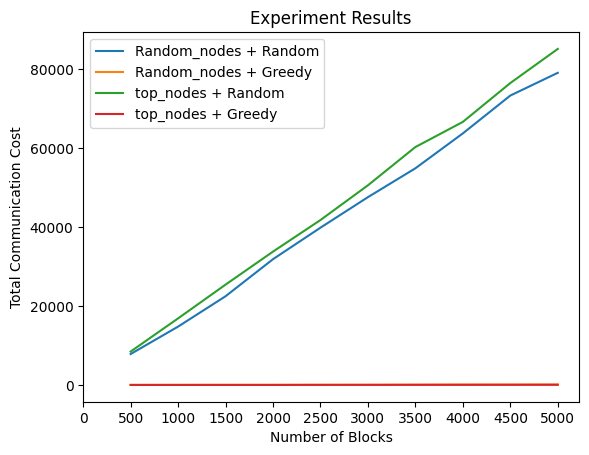

In [13]:
# グラフの設定
plt.plot(experiment, random_nodes_random_result, label='Random_nodes + Random')
plt.plot(experiment, random_nodes_greedy_result, label='Random_nodes + Greedy')
plt.plot(experiment, top_nodes_random_result, label='top_nodes + Random')
plt.plot(experiment, top_nodes_greedy_result, label='top_nodes + Greedy')

plt.xlabel('Number of Blocks')
plt.ylabel('Total Communication Cost')
plt.title('Experiment Results')
plt.legend()
# x軸の目盛り設定
plt.xticks(range(0, max(experiment)+1, 500))
# グラフの保存
plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/graph1.png')
# グラフの表示
plt.show()


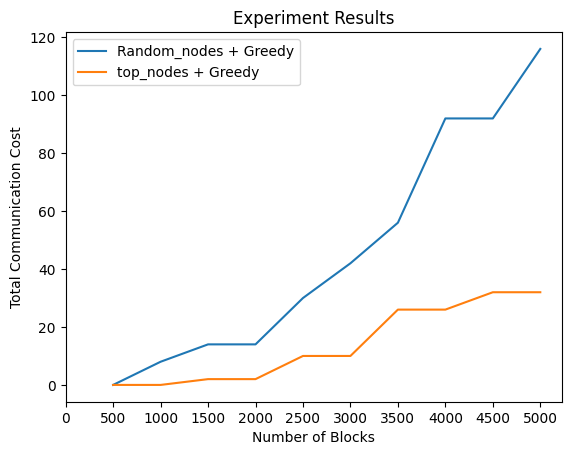

In [14]:
plt.plot(experiment, random_nodes_greedy_result, label='Random_nodes + Greedy')
plt.plot(experiment, top_nodes_greedy_result, label='top_nodes + Greedy')

plt.xlabel('Number of Blocks')
plt.ylabel('Total Communication Cost')
plt.title('Experiment Results')
plt.legend()
# x軸の目盛り設定
plt.xticks(range(0, max(experiment)+1, 500))
# グラフの保存
plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/graph2.png')
# グラフの表示
plt.show()
